In [ ]:
import numpy as np
import pandas as pd
import os
import time
import random
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from skimage.feature import hog

import PIL
import cv2
import pickle

In [ ]:
!pip install unrar
!unrar x /content/BatImageDataset.rar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal


Extracting from /content/BatImageDataset.rar

Creating    BatImageDataset                                           OK
Creating    BatImageDataset/bat                                       OK
Extracting  BatImageDataset/bat/bat00.jpg                                  0%  OK 
Extracting  BatImageDataset/bat/bat1.jpg                                   0%  OK 
Extracting  BatImageDataset/bat/bat10.jpg                                  1%  OK 
Extracting  BatImageDataset/bat/bat11.jpg                                  1%  OK 
Extracting  BatImageDataset/bat/bat111.jpg                                 2%  OK 
Extracting  BatImageDataset/bat/bat112.jpg                                 2%  OK 
Extracting  BatImageDataset/bat/bat113.jpg                                 2%

In [ ]:
img_paths = glob("/content/BatImageDataset/bat"+"/*")[:200]
neg_paths = glob("/content/BatImageDataset/notBat"+"/*")[:200]
'''
for class_path in glob("/content/Datasets/Images/notBat"+"/*"):
  paths = random.choices(glob(class_path+"/*"),k=10)
  neg_paths = paths + neg_paths
'''
print("There are {} bat images in the dataset".format(len(img_paths)))
print("There are {} negative images in the dataset".format(len(neg_paths)))

There are 134 bat images in the dataset
There are 93 negative images in the dataset


In [ ]:
img_paths[:5]

['/content/BatImageDataset/bat/bat56.jpg',
 '/content/BatImageDataset/bat/bat73.jpg',
 '/content/BatImageDataset/bat/bat120.jpg',
 '/content/BatImageDataset/bat/bat173.jpg',
 '/content/BatImageDataset/bat/bat54.jpg']

<ipython-input-5-d253ec3bbbd5>:2: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  hog_features,visualized = hog(example_image,orientations=9,pixels_per_cell=(16,16),


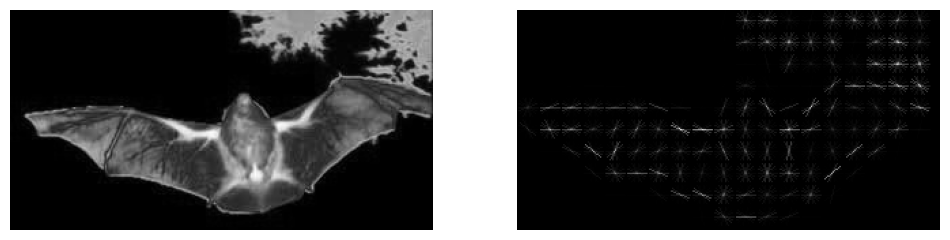

In [ ]:
example_image = np.asarray(PIL.Image.open("/content/BatImageDataset/bat/bat112.jpg"))
hog_features,visualized = hog(example_image,orientations=9,pixels_per_cell=(16,16),
                              cells_per_block=(2,2),
                              visualize=True,
                              multichannel=True
                             )

fig = plt.figure(figsize=(12,6))
fig.add_subplot(1,2,1)
plt.imshow(example_image)
plt.axis("off")
fig.add_subplot(1,2,2)
plt.imshow(visualized,cmap="gray")
plt.axis("off")
plt.show()

In [ ]:
'''import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data, exposure

hog_image_rescaled = exposure.rescale_intensity(visualized, in_range=(0, 10))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)


ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('HOG features')

plt.show()
'''






"import matplotlib.pyplot as plt\nfrom skimage.feature import hog\nfrom skimage import data, exposure\n\nhog_image_rescaled = exposure.rescale_intensity(visualized, in_range=(0, 10))\n\nfig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)\n\n\nax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)\nax2.set_title('HOG features')\n\nplt.show()\n"

In [ ]:
hog_features.shape

(5832,)

In [ ]:
pos_images = []
neg_images = []

pos_labels = np.ones(len(img_paths))
neg_labels = np.zeros(len(neg_paths))

start = time.time()

for img_path in img_paths:
    img = np.asarray(PIL.Image.open(img_path))
    # We don't have to use RGB channels to extract features, Grayscale is enough.
    img = cv2.cvtColor(cv2.resize(img,(640,640)),cv2.COLOR_RGB2GRAY)
    img = hog(img,orientations=9,pixels_per_cell=(16,16),
              cells_per_block=(2,2)
             )
    pos_images.append(img)

for neg_path in neg_paths:
    img = np.asarray(PIL.Image.open(neg_path))
    img = cv2.cvtColor(cv2.resize(img,(640,640)),cv2.COLOR_RGB2GRAY)
    img = hog(img,orientations=9,pixels_per_cell=(16,16),
              cells_per_block=(2,2)
             )
    neg_images.append(img)

x = np.asarray(pos_images + neg_images)
y = np.asarray(list(pos_labels) + list(neg_labels))

processTime = round(time.time()-start,2)
print("Reading images and extracting features has taken {} seconds".format(processTime))

print("Shape of image set",x.shape)
print("Shape of labels",y.shape)

Reading images and extracting features has taken 23.36 seconds
Shape of image set (227, 54756)
Shape of labels (227,)


In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(158, 54756)
(69, 54756)
(158,)
(69,)


In [ ]:
# Creating a SVC object
svc = SVC(kernel = 'rbf', C = 1.0)

# We'll use Cross Validation Grid Search to find best parameters.
# Classifier will be trained using each parameter
svc.fit(x_train,y_train)

y_pred = svc.predict(x_test)
#print("Accuracy score of model is ",accuracy_score(y_pred=y_pred,y_true=y_test)*100)
print("Accuracy: {:.2f}%".format(accuracy_score(y_pred=y_pred,y_true=y_test) * 100))

Accuracy: 95.65%


In [ ]:
from joblib import dump
# Save the trained SVM model as a pkl file
dump(svc, 'svm_model.pkl')

['svm_model.pkl']

In [ ]:
import cv2
import numpy as np
import joblib

# Load the pre-trained SVM model
svm_model = joblib.load('svm_model.pkl')

#input_image = cv2.imread('/content/validation.jpg')
#input_image = cv2.imread('/content/bat112.jpg')
input_image = np.asarray(PIL.Image.open("/content/BatImageDataset/bat/bat112.jpg"))

gray_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
resized_image = cv2.resize(gray_image, (640, 640))

'''
# Convert the input image to grayscale
gray_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)

# Resize the input image to a fixed size (e.g. 64x64 pixels)
resized_image = cv2.resize(gray_image, (640, 640))

# Extract HOG features from the resized image
hog = cv2.HOGDescriptor()
feature_vector = hog.compute(resized_image)

# Reshape the feature vector to a 1D numpy array
feature_vector = feature_vector.reshape(1, -1)
'''
hog_features,visualized = hog(resized_image,orientations=9,pixels_per_cell=(16,16),
                              cells_per_block=(2,2),
                              visualize=True,
                              multichannel=True
                             )

# Predict whether the input image contains an object or not using the SVM model
prediction = svm_model.predict(hog_features)

# Get the confidence score for the prediction
confidence = svm_model.decision_function(hog_features)

# Display the input image with the prediction and confidence score
if prediction == 1:
    cv2.putText(input_image, "Object Detected: Confidence = {}".format(confidence[0]), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
else:
    cv2.putText(input_image, "No Object Detected: Confidence = {}".format(confidence[0]), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

cv2.imshow('Input Image', input_image)
cv2.waitKey(0)
cv2.destroyAllWindows()



FileNotFoundError: ignored

Confusion matrix:
[[26  1]
 [ 2 40]]


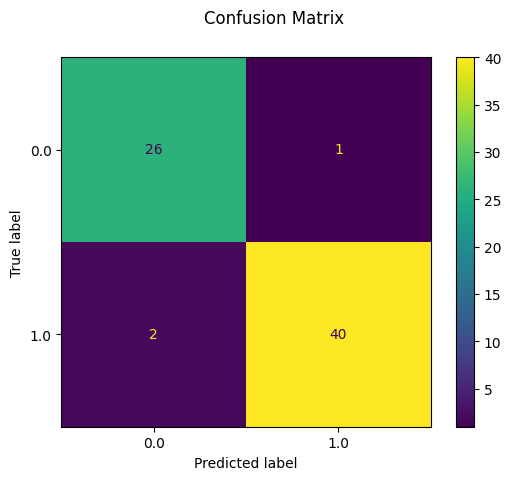

In [ ]:
from sklearn import metrics
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()